In [1]:
from bmtool.analysis import spikes, lfp

config_path = '/home/gjgpb9/cortex_modeling/V1_Layer5/Model-Parameters/simulation_config_baseline.json'
output_path = '../network_to_analysis/short'
fs = 400

df = spikes.load_spikes_to_df(spike_file=f'{output_path}/spikes.h5',network_name='cortex',config=config_path)
spike_rate = spikes.get_population_spike_rate(df,config=config_path,fs=fs)

ecp = lfp.load_ecp_to_xarray(ecp_file=f'{output_path}/ecp.h5')
lfp_processed = lfp.ecp_to_lfp(ecp_data=ecp,downsample_freq=fs)

Grabbing first network; specify a network name to ensure correct node population is selected.



FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 100 Hz                        
                                 Frequency Resolution is 1.56 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -4.1190, 1.6183                                          
                                                                                                  
                             

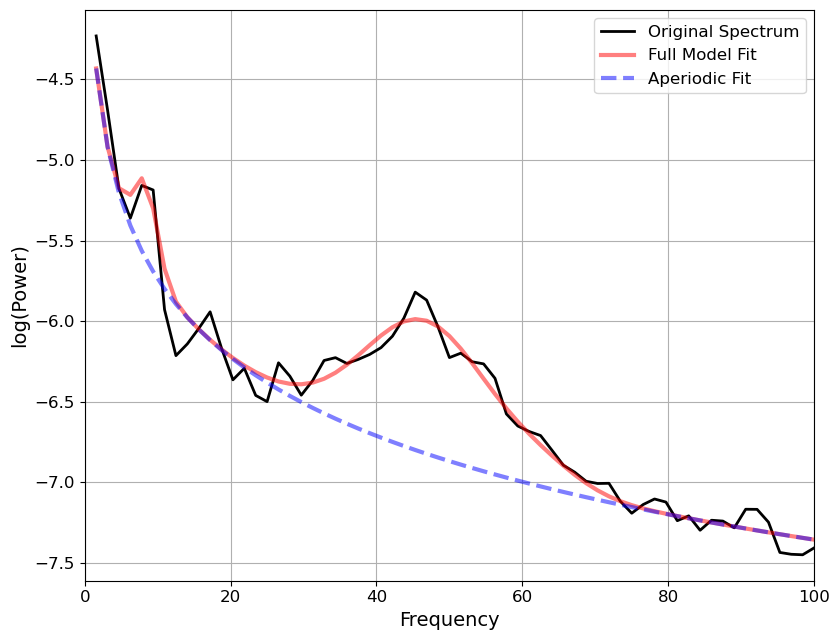

In [2]:
import scipy.signal as ss

hz, pxx = ss.welch(x=lfp_processed,fs=fs)
results = lfp.fit_fooof(f=hz,pxx=pxx[0],plot=True,report=True,freq_range=[0,100],plt_log=False,plt_range=[0,100])


FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 100 Hz                        
                                 Frequency Resolution is 1.56 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -1.6241, -0.1448                                         
                                                                                                  
                             

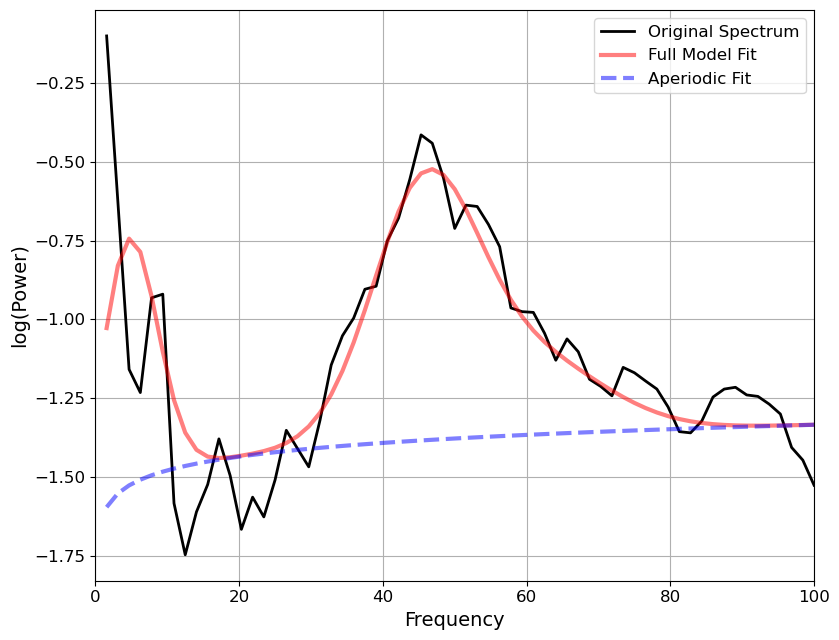

In [3]:
hz, pxx = ss.welch(x=spike_rate['FSI'],fs=fs)
results = lfp.fit_fooof(f=hz,pxx=pxx,plot=True,report=True,freq_range=[0,100],plt_log=False,plt_range=[0,100])


FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 100 Hz                        
                                 Frequency Resolution is 1.56 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -0.7502, 0.6977                                          
                                                                                                  
                             

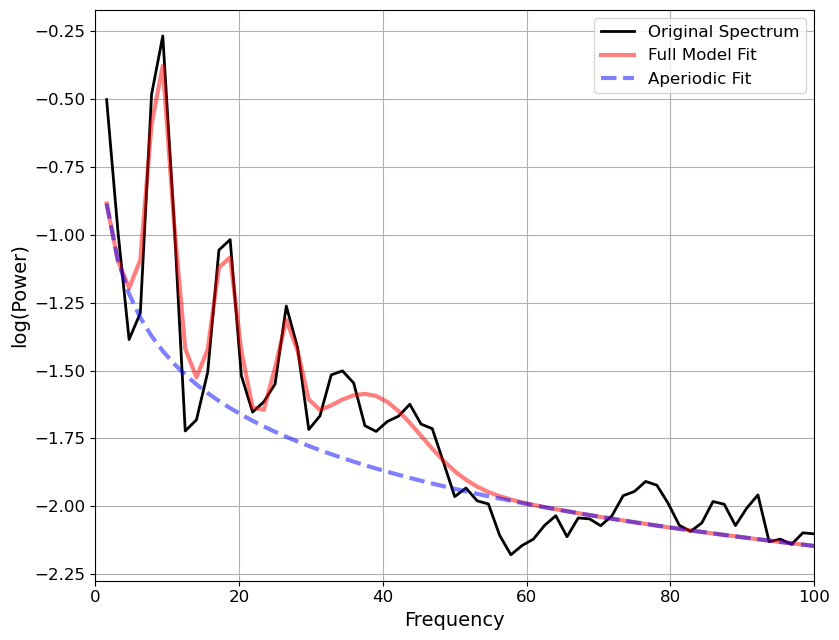

In [4]:
hz, pxx = ss.welch(x=spike_rate['LTS'],fs=fs)
results = lfp.fit_fooof(f=hz,pxx=pxx,plot=True,report=True,freq_range=[0,100],plt_log=False,plt_range=[0,100])

### Makes sure to change the freq_of_interest to be the center frequency of your oscillation

In [5]:
plv = lfp.calculate_plv(spike_rate['FSI'],lfp_processed[0],fs=fs,freq_of_interest=45.)
print(plv)
plv = lfp.calculate_plv(spike_rate['LTS'],lfp_processed[0],fs=fs,freq_of_interest=45.)
print(plv)

0.8055071098112256
0.4116530108187518


In [6]:
plv = lfp.calculate_ppc1(df[df['pop_name']=='FSI']['timestamps'].values,lfp_processed[0],spike_fs=1000,lfp_fs=400,freq_of_interest=45.,method='wavelet')
print(plv[0])
plv = lfp.calculate_ppc1(df[df['pop_name']=='LTS']['timestamps'].values,lfp_processed[0],spike_fs=1000,lfp_fs=400,freq_of_interest=45.,method='wavelet')
print(plv[0])

0.007771154074754839
0.00362673684801665
0.00362673684801665


### You can also plot the entrainment for different frequencies 

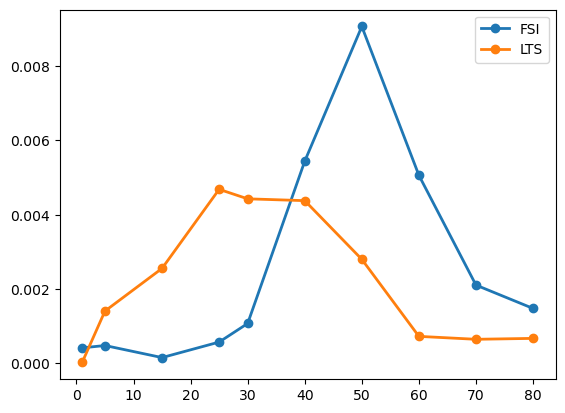

In [24]:
freqs = [1,5,15,25,30,40,50,60,70,80]
plv_list_FSI = []
plv_list_LTS = []
for i in range(len(freqs)):
    plv_list_FSI.append(lfp.calculate_ppc1(df[df['pop_name']=='FSI']['timestamps'].values,lfp_processed[0],spike_fs=1000,lfp_fs=400,freq_of_interest=freqs[i],method='wavelet')[0])
    plv_list_LTS.append(lfp.calculate_ppc1(df[df['pop_name']=='LTS']['timestamps'].values,lfp_processed[0],spike_fs=1000,lfp_fs=400,freq_of_interest=freqs[i],method='wavelet')[0])
    
plt.plot(freqs,plv_list_FSI,'o-', linewidth=2,label="FSI")
plt.plot(freqs,plv_list_LTS,'o-', linewidth=2,label='LTS')
plt.legend()
plt.show()

# we can see that our FSI cells are around gamma and our LTS cells are around beta which is a good result to see